In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Load the dataset

In [31]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
store = pd.read_csv('store.csv')

print('train.shape: {}'.format(train.shape))
print('test.shape: {}'.format(test.shape))
print('store.shape: {}'.format(store.shape))

train.shape: (1017209, 9)
test.shape: (41088, 8)
store.shape: (1115, 10)


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
train.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [33]:
test.head()

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0
3   4      8          4  2015-09-17   1.0      1            0              0
4   5      9          4  2015-09-17   1.0      1            0              0

In [34]:
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

### The target: Sales

In [35]:
train.Sales.isnull().sum()

0

No missing values in the target

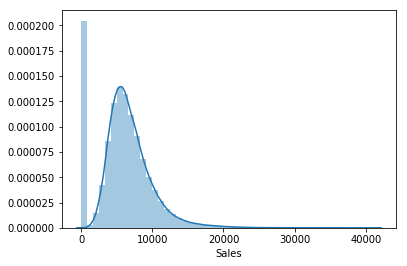

In [36]:
sns.distplot(train.Sales)

The target shows a right skewed distribution with a lot of zeros.

In [37]:
print('Number of rows with 0 sales: {}'.format(train[train.Sales==0].shape[0]))
print('Number of rows with 0 sales when the store is closed: {}'.format(train[(train.Sales==0) & (train.Open==0)].shape[0]))
print('Number of rows with 0 sales when the store is open: {}'.format(train[(train.Sales==0) & (train.Open==1)].shape[0]))
print('Number of rows with >0 sales when the store is closed: {}'.format(train[(train.Sales>0) & (train.Open==0)].shape[0]))

Number of rows with 0 sales: 172871
Number of rows with 0 sales when the store is closed: 172817
Number of rows with 0 sales when the store is open: 54
Number of rows with >0 sales when the store is closed: 0


No store makes any sales when closed, which makes sense.

However, there are 54 rows in which the store was open but didn't makes any sales, these may be caused by some other factors: very bad weather, for example.

These 54 rows will be considered as outliers and be droped.

In [38]:
train = train.drop(train[(train.Sales==0) & (train.Open==1)].index, axis=0)

### Missing values

In [39]:
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [40]:
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [41]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

There are some missing values in test.Open, we can fill it in with the most common value.

In [42]:
test['Open'] = test.Open.fillna(test.Open.mode()[0])

For the missin values in store table:

**CompetitionDistance**

In [43]:
store[store.CompetitionDistance.isnull()]

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov

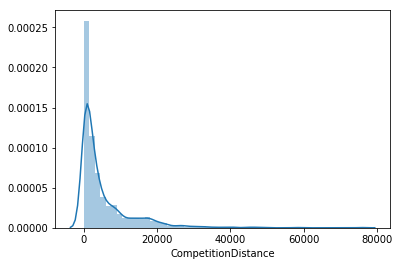

In [44]:
sns.distplot(store.CompetitionDistance.fillna(0))

This 3 store may have no competition nearby, so I decide to fill in this 3 missing values with the max distance + 10000

In [46]:
store['CompetitionDistance'] = store.CompetitionDistance.fillna(store.CompetitionDistance.max() + 10000)

**CompetitionOpenSinceMonth, CompetitionOpenSinceYear**

In [47]:
store[store.CompetitionOpenSinceMonth.isnull() & store.CompetitionOpenSinceYear.isnull()].shape

(351, 10)

These 2 values are always missing at the same time.

The missing values in this 2 column may be caused by unknowing the opening time of the competitor, so we can make it a special case by filling in -1.

**Promo2SinceWeek, Promo2SinceYear, PromoInterval**

In [48]:
store[(store.Promo2==0)&(store.Promo2SinceWeek.isnull())&(store.Promo2SinceYear.isnull())&(store.PromoInterval.isnull())].shape

(544, 10)

These 3 values were missing when the store did not participate in promo2.

As for CompetitionOpen attributes, we can fill in -1

### Store

In [49]:
train_store = pd.merge(train, store, how='left', on='Store')

In [50]:
train_store.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth    320687
CompetitionOpenSinceYear     320687
Promo2                            0
Promo2SinceWeek              508016
Promo2SinceYear              508016
PromoInterval                508016
dtype: int64

### Date

In [51]:
train_store.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              NaN              NaN              NaN  
1             13.0           2010.0  Jan,Apr,Jul,Oct  
2             14.0           2011.0  Jan,Apr,Jul,Oct  
3              NaN              NaN              NaN  
4              NaN              NaN              NaN

In [52]:
train_store['Date'] = pd.to_datetime(train_store.Date)
train_store['Year'] = train_store.Date.dt.year
train_store['Month'] = train_store.Date.dt.month
train_store['Day'] = train_store.Date.dt.day

#### Year

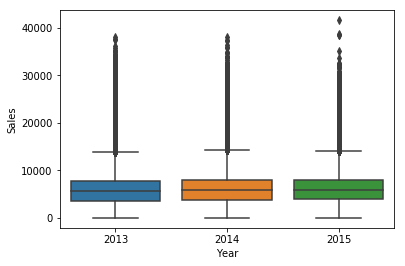

In [53]:
sns.boxplot(data=train_store, x='Year', y='Sales')

#### Month

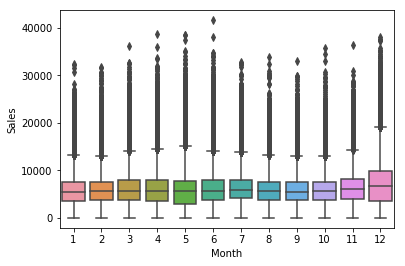

In [54]:
sns.boxplot(data=train_store, x='Month', y='Sales')

#### Day

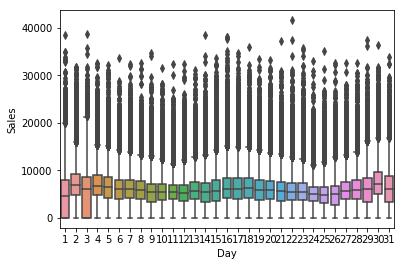

In [55]:
sns.boxplot(data=train_store, x='Day', y='Sales')

### Some other catigorical features

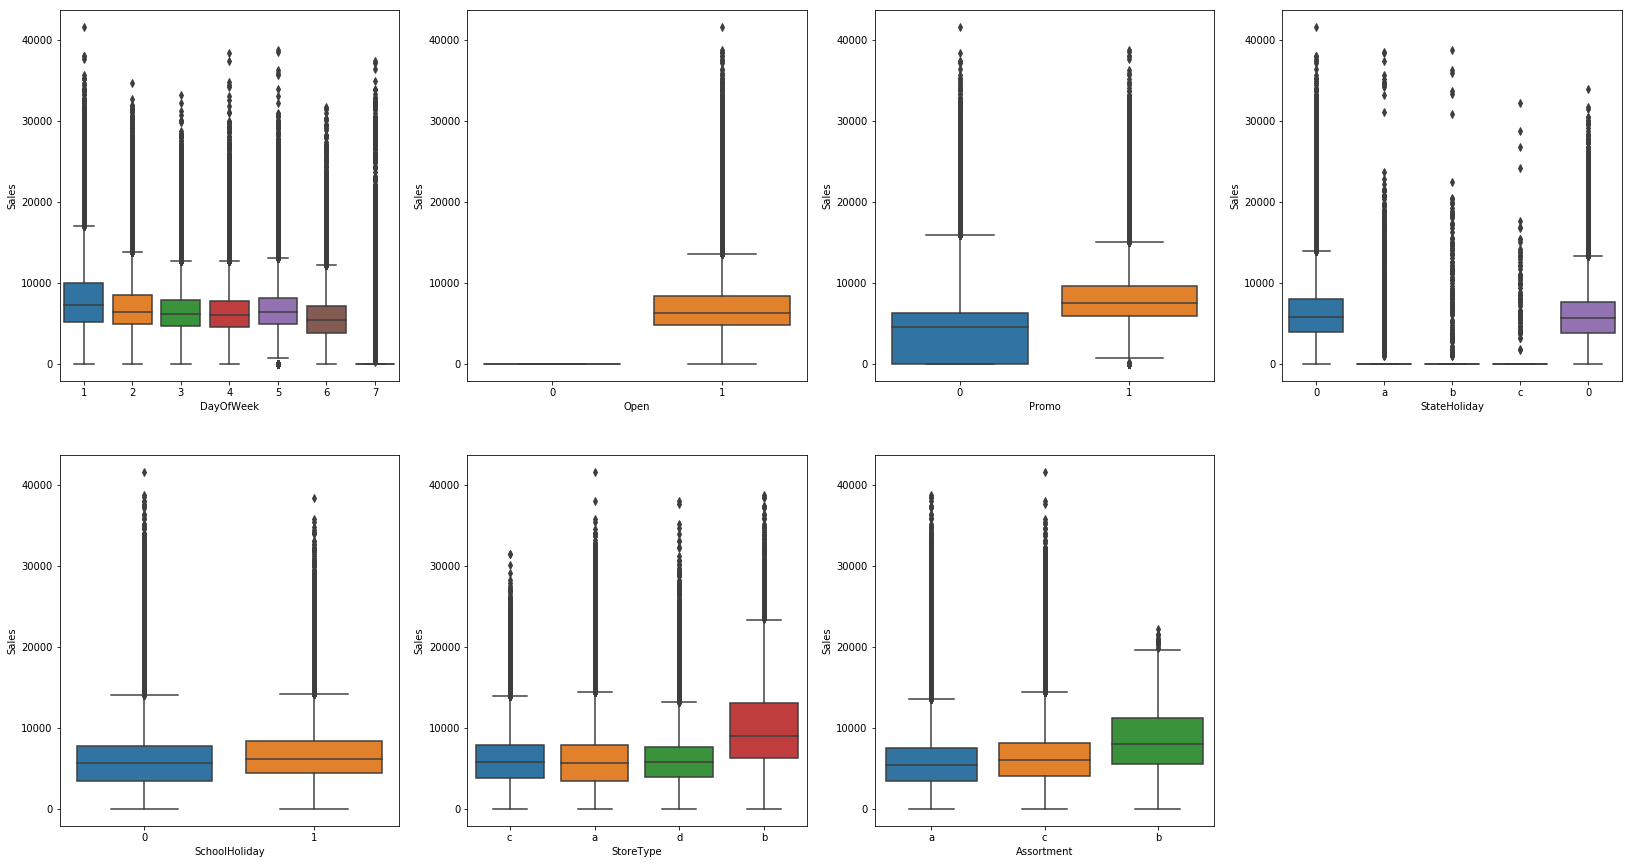

In [56]:
feats = ['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment']
plt.figure(figsize=(28, 15))
for i, feat in enumerate(feats):
    plt.subplot(2, 4, i+1)
    sns.boxplot(data=train_store, x=feat, y='Sales')
plt.show()

### Check out the differences between stores

In [ ]:
f.tight_layout(h_pad=)

In [94]:
def plot_10_store_sales():
    all_stores = train_store.Store.unique().tolist()
    chosen_store_ids = np.random.choice(all_stores, 10, replace=False)
    f = plt.figure(figsize=(30, 60))
    for i, store_id in enumerate(chosen_store_ids):
        plt.subplot(10, 1, i+1)
        sns.lineplot(data=train_store[train_store.Store==store_id], x='Date', y='Sales')
        plt.title('Store ' + str(store_id))
    plt.show()

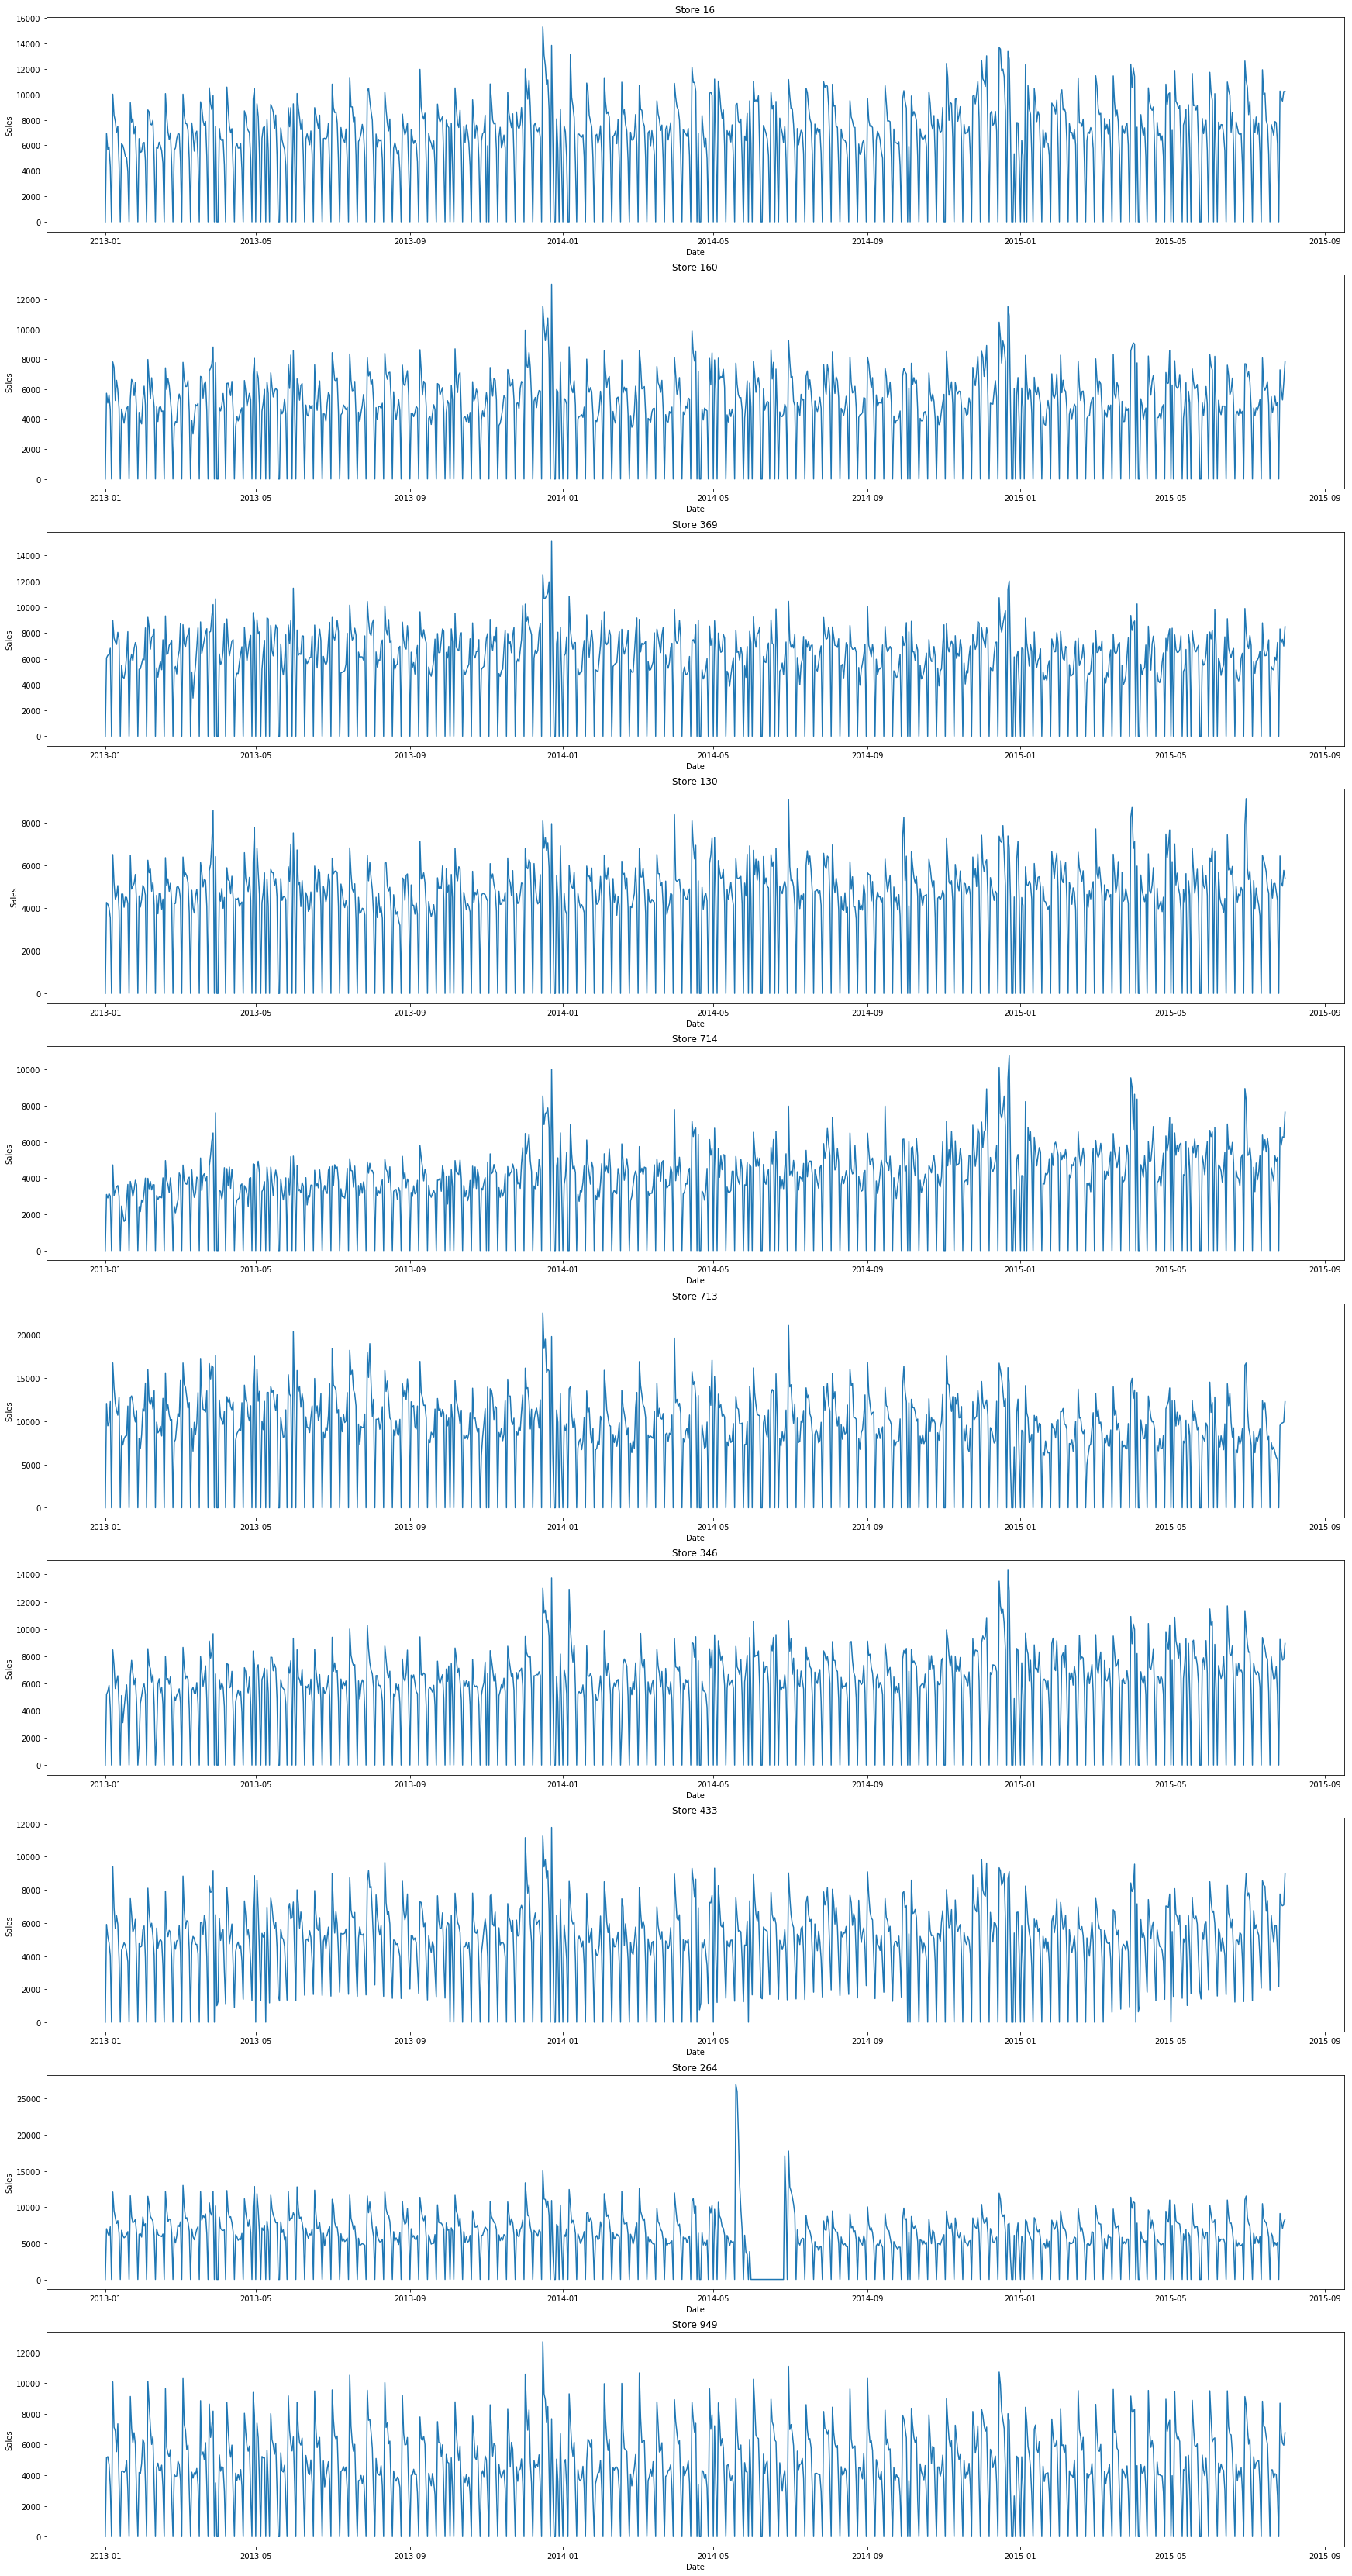

In [95]:
plot_10_store_sales()

In [106]:
def plot_store_sales_during(store_id, start_time, end_time):
    tmp = train_store[(train_store.Store==store_id) & (train_store.Date>pd.to_datetime(start_time)) & (train_store.Date<pd.to_datetime(end_time))]
    plt.figure(figsize=(20, 4))
    sns.lineplot(data=tmp, x='Date', y='Sales')
    plt.show()

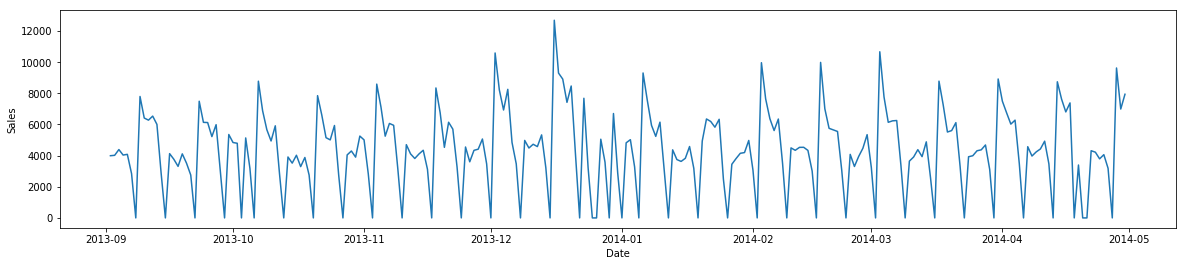

In [107]:
plot_store_sales_during(949, '2013-09-01', '2014-05-01')

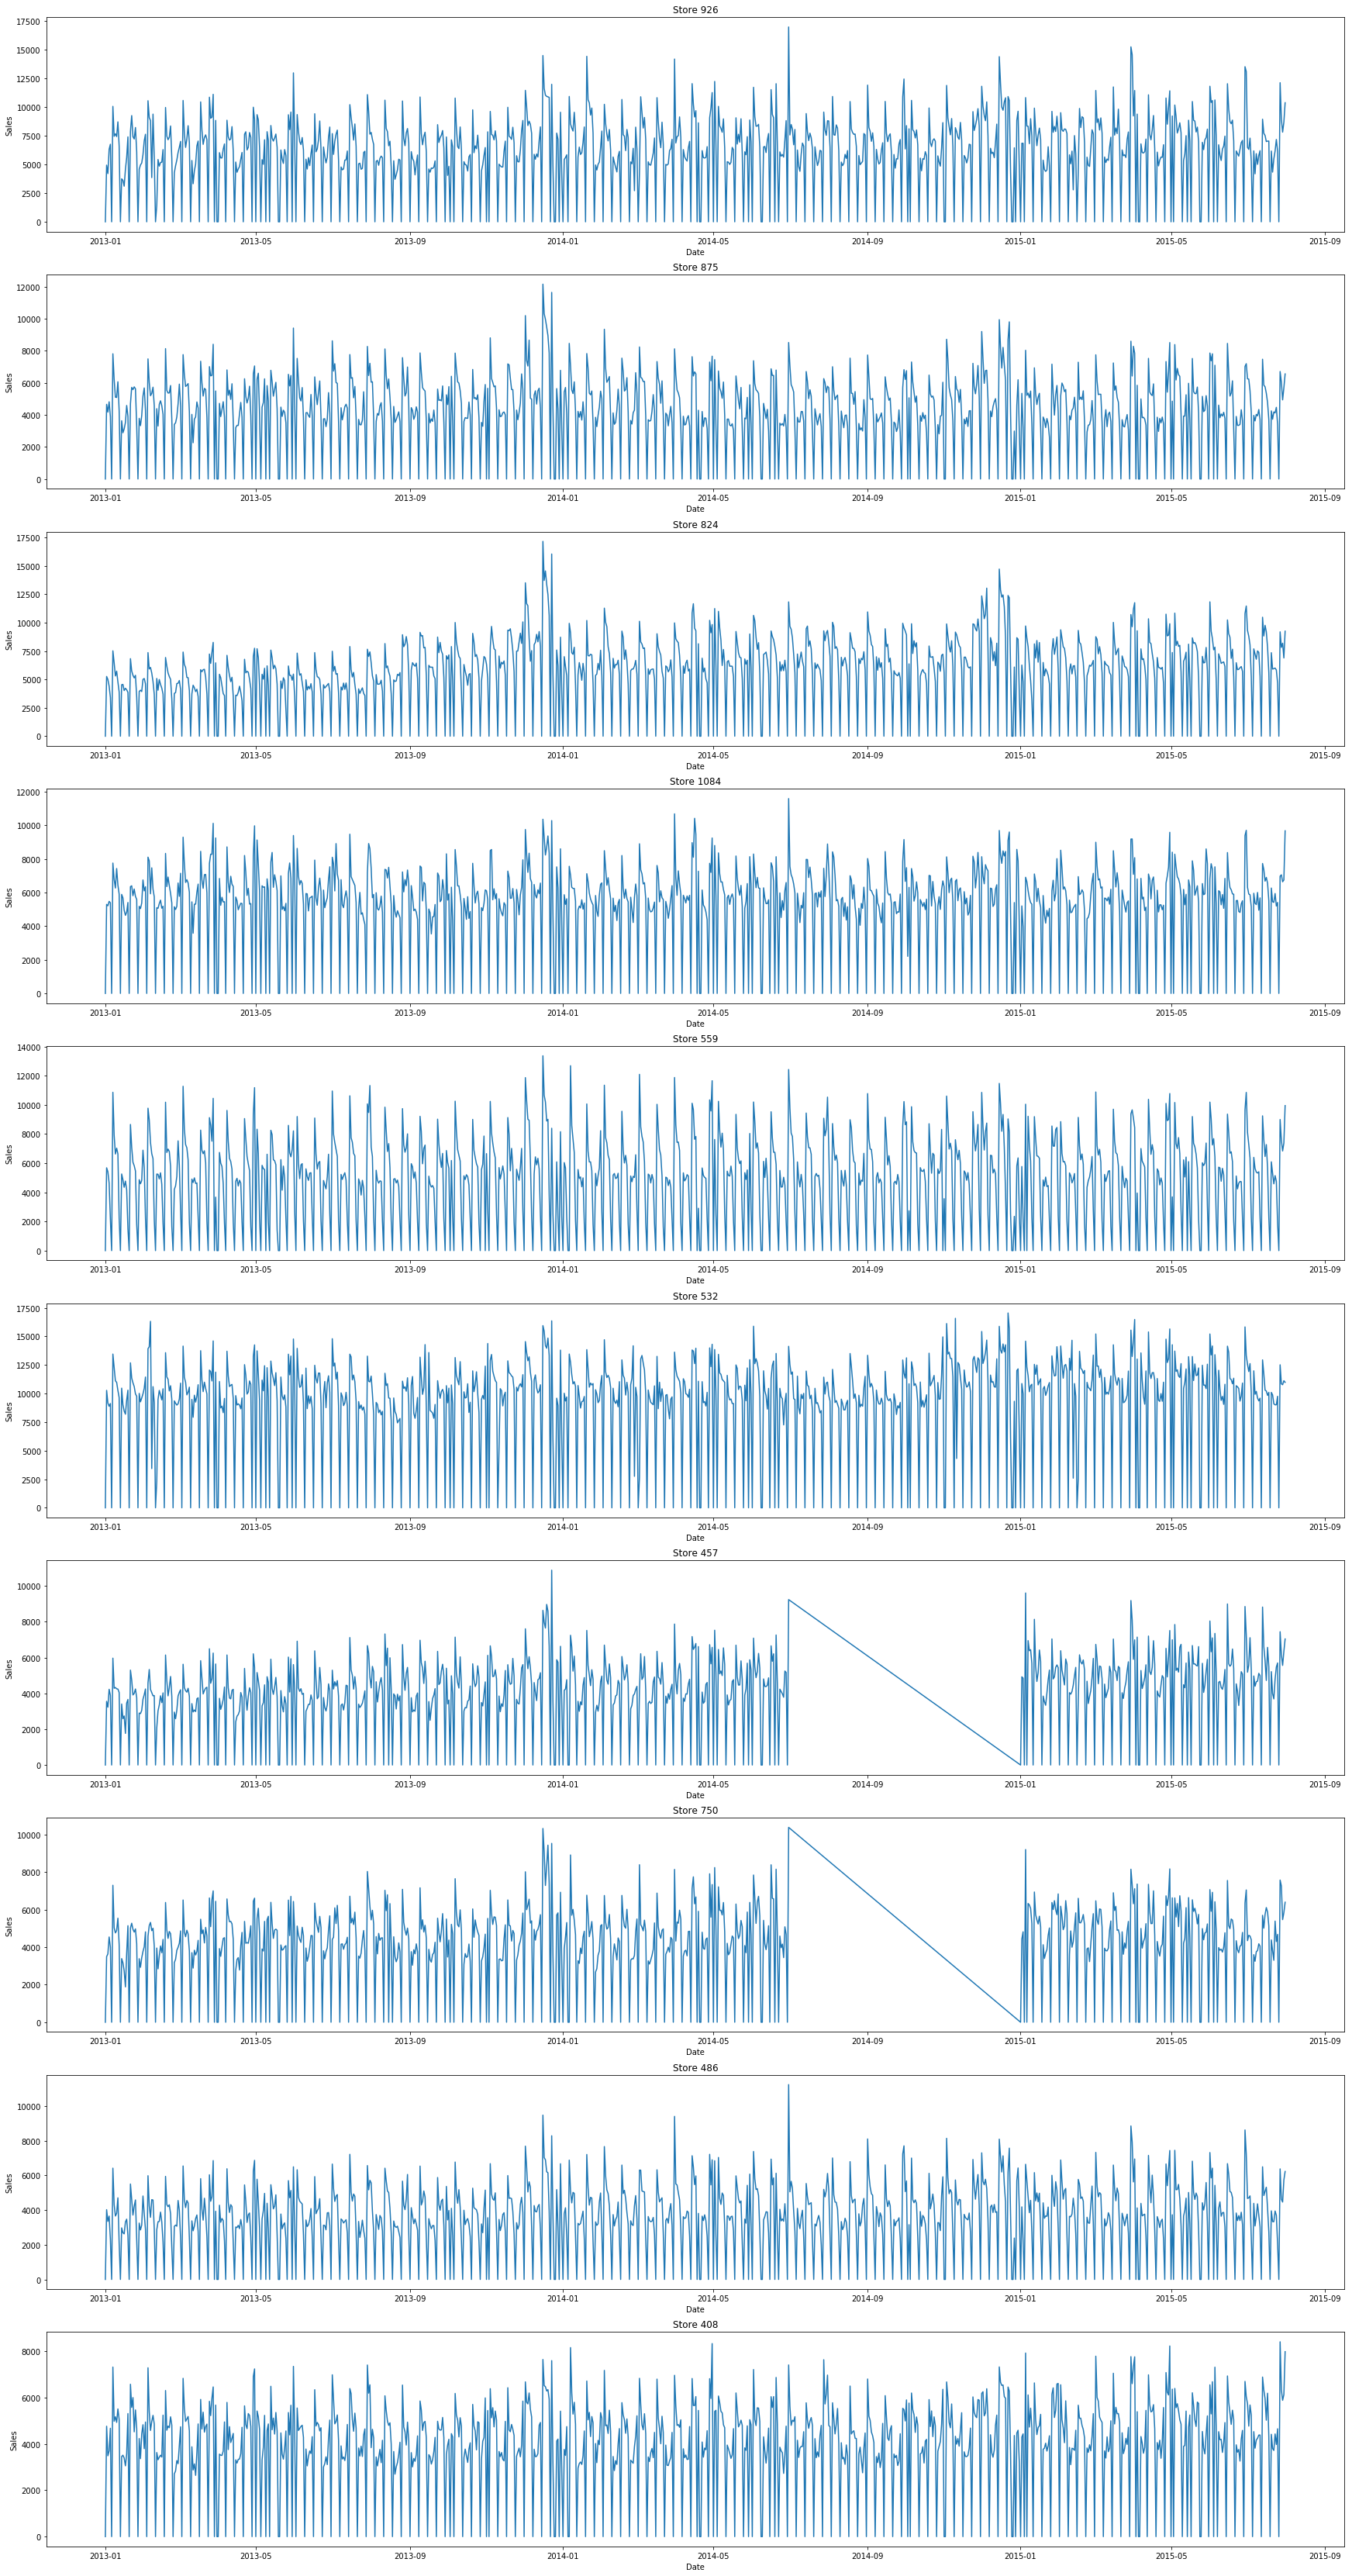

In [108]:
plot_10_store_sales()

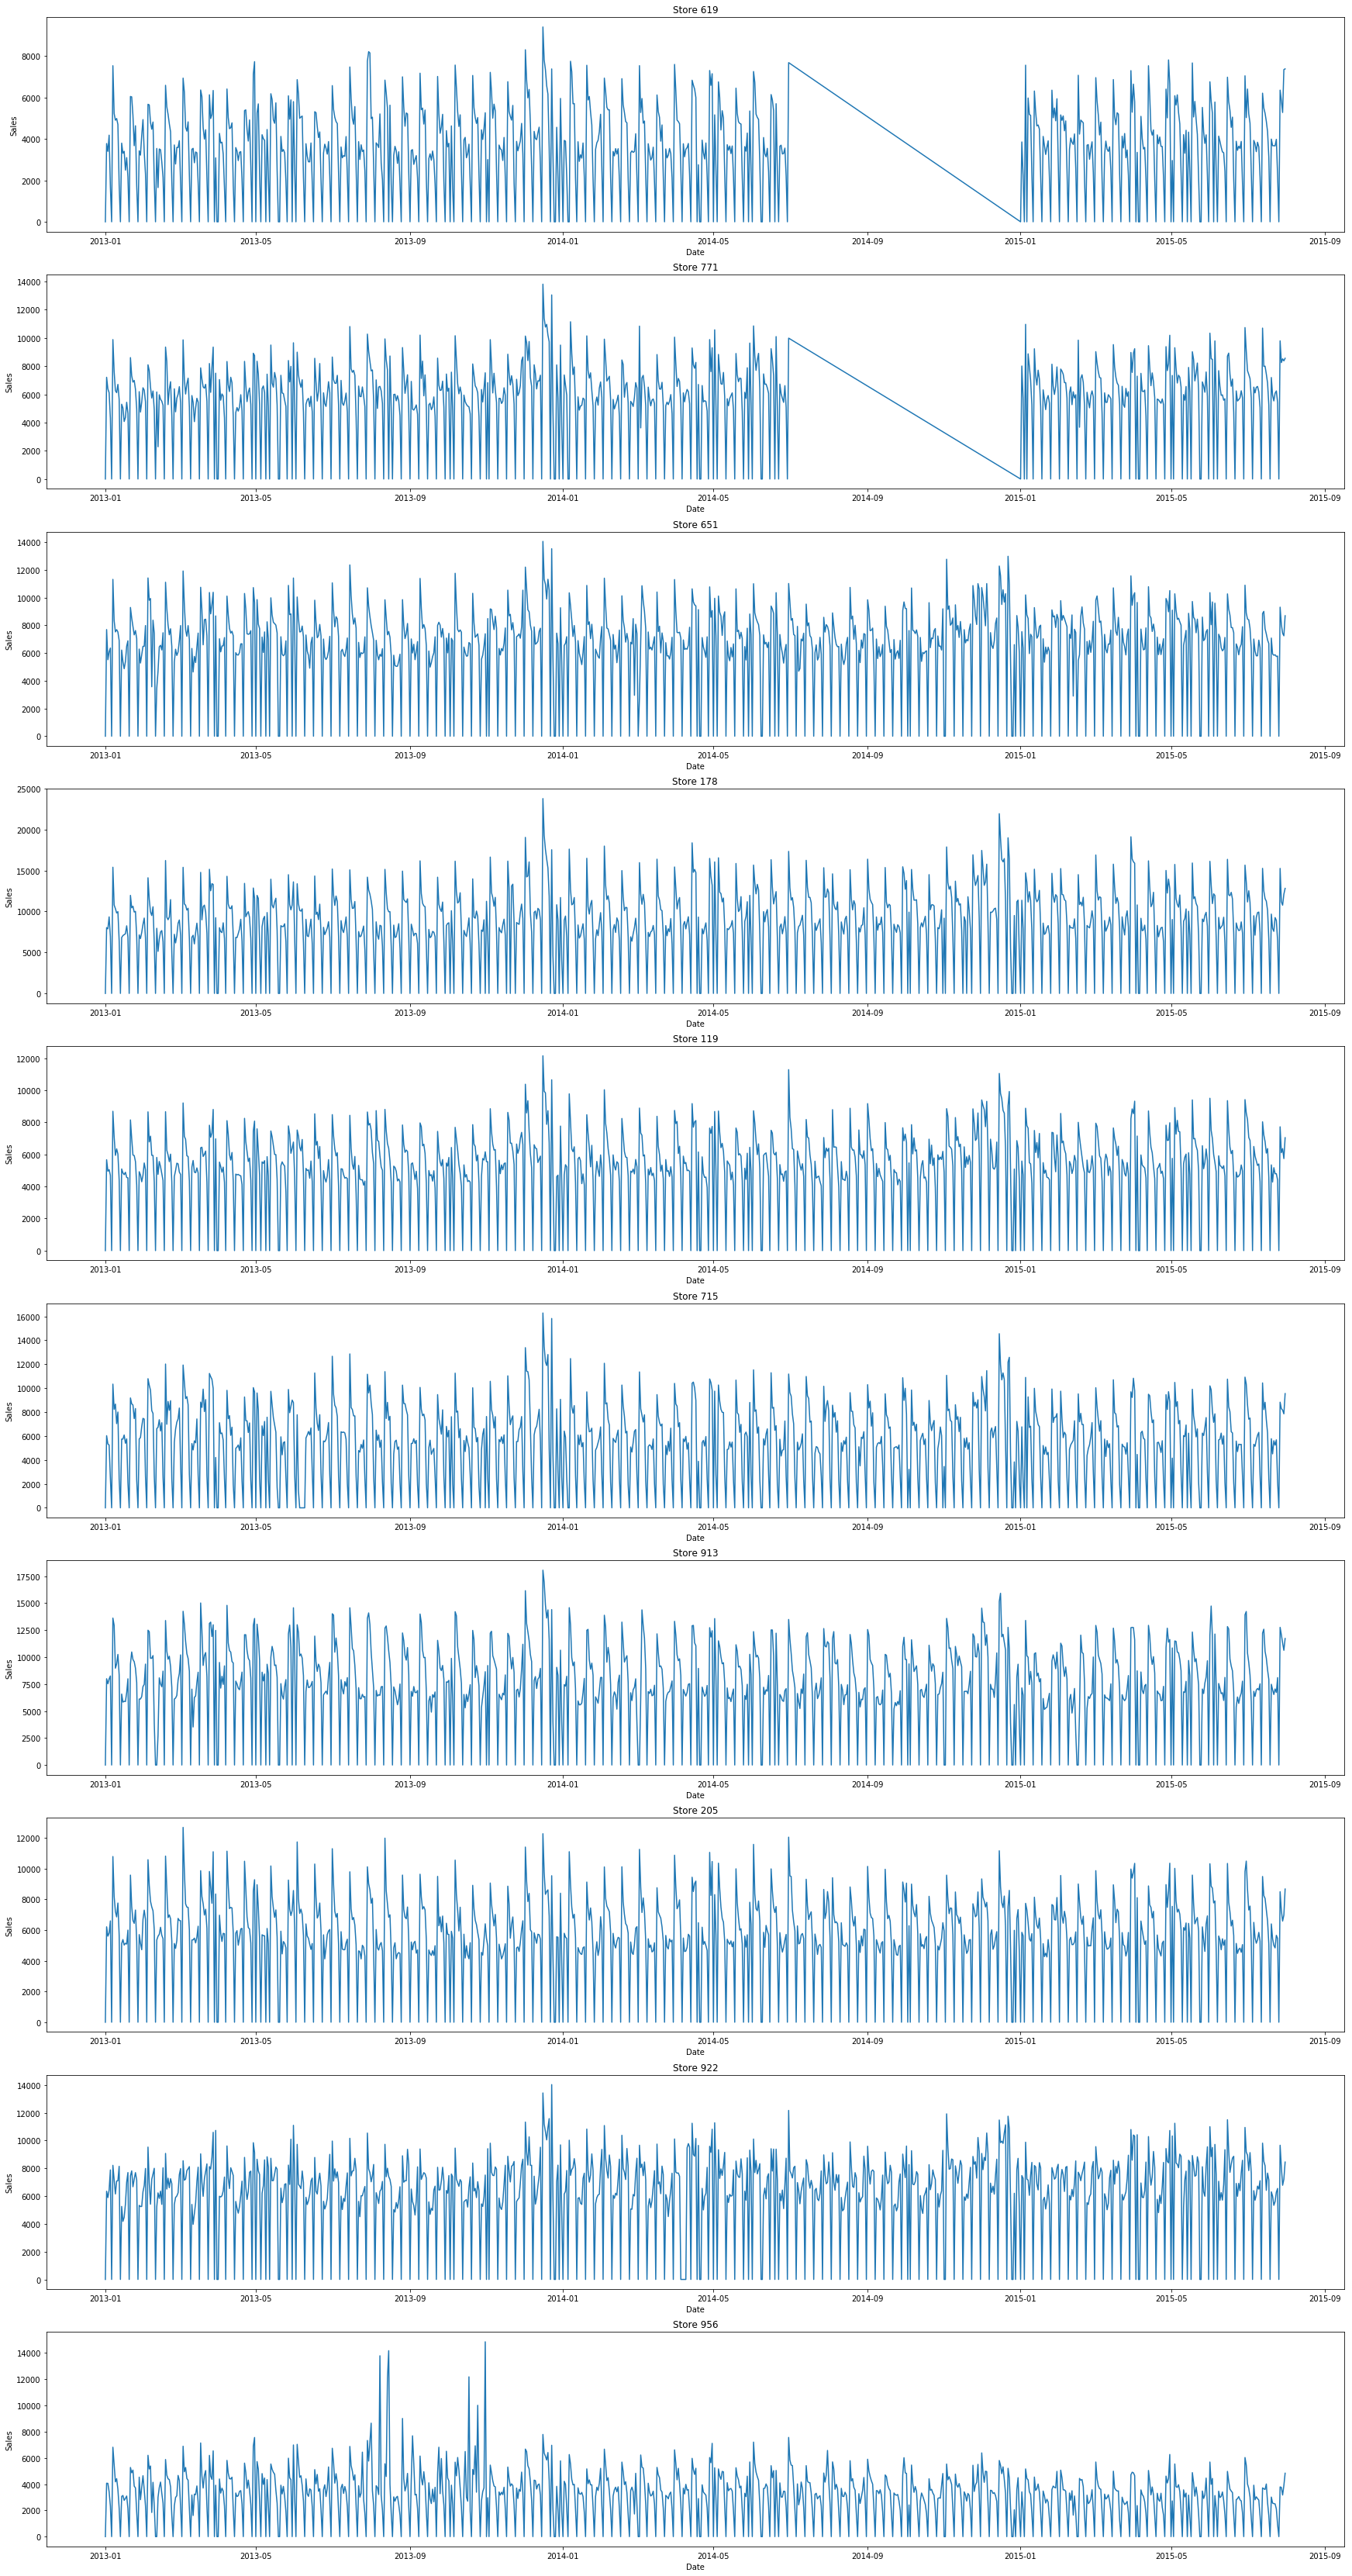

In [109]:
plot_10_store_sales()

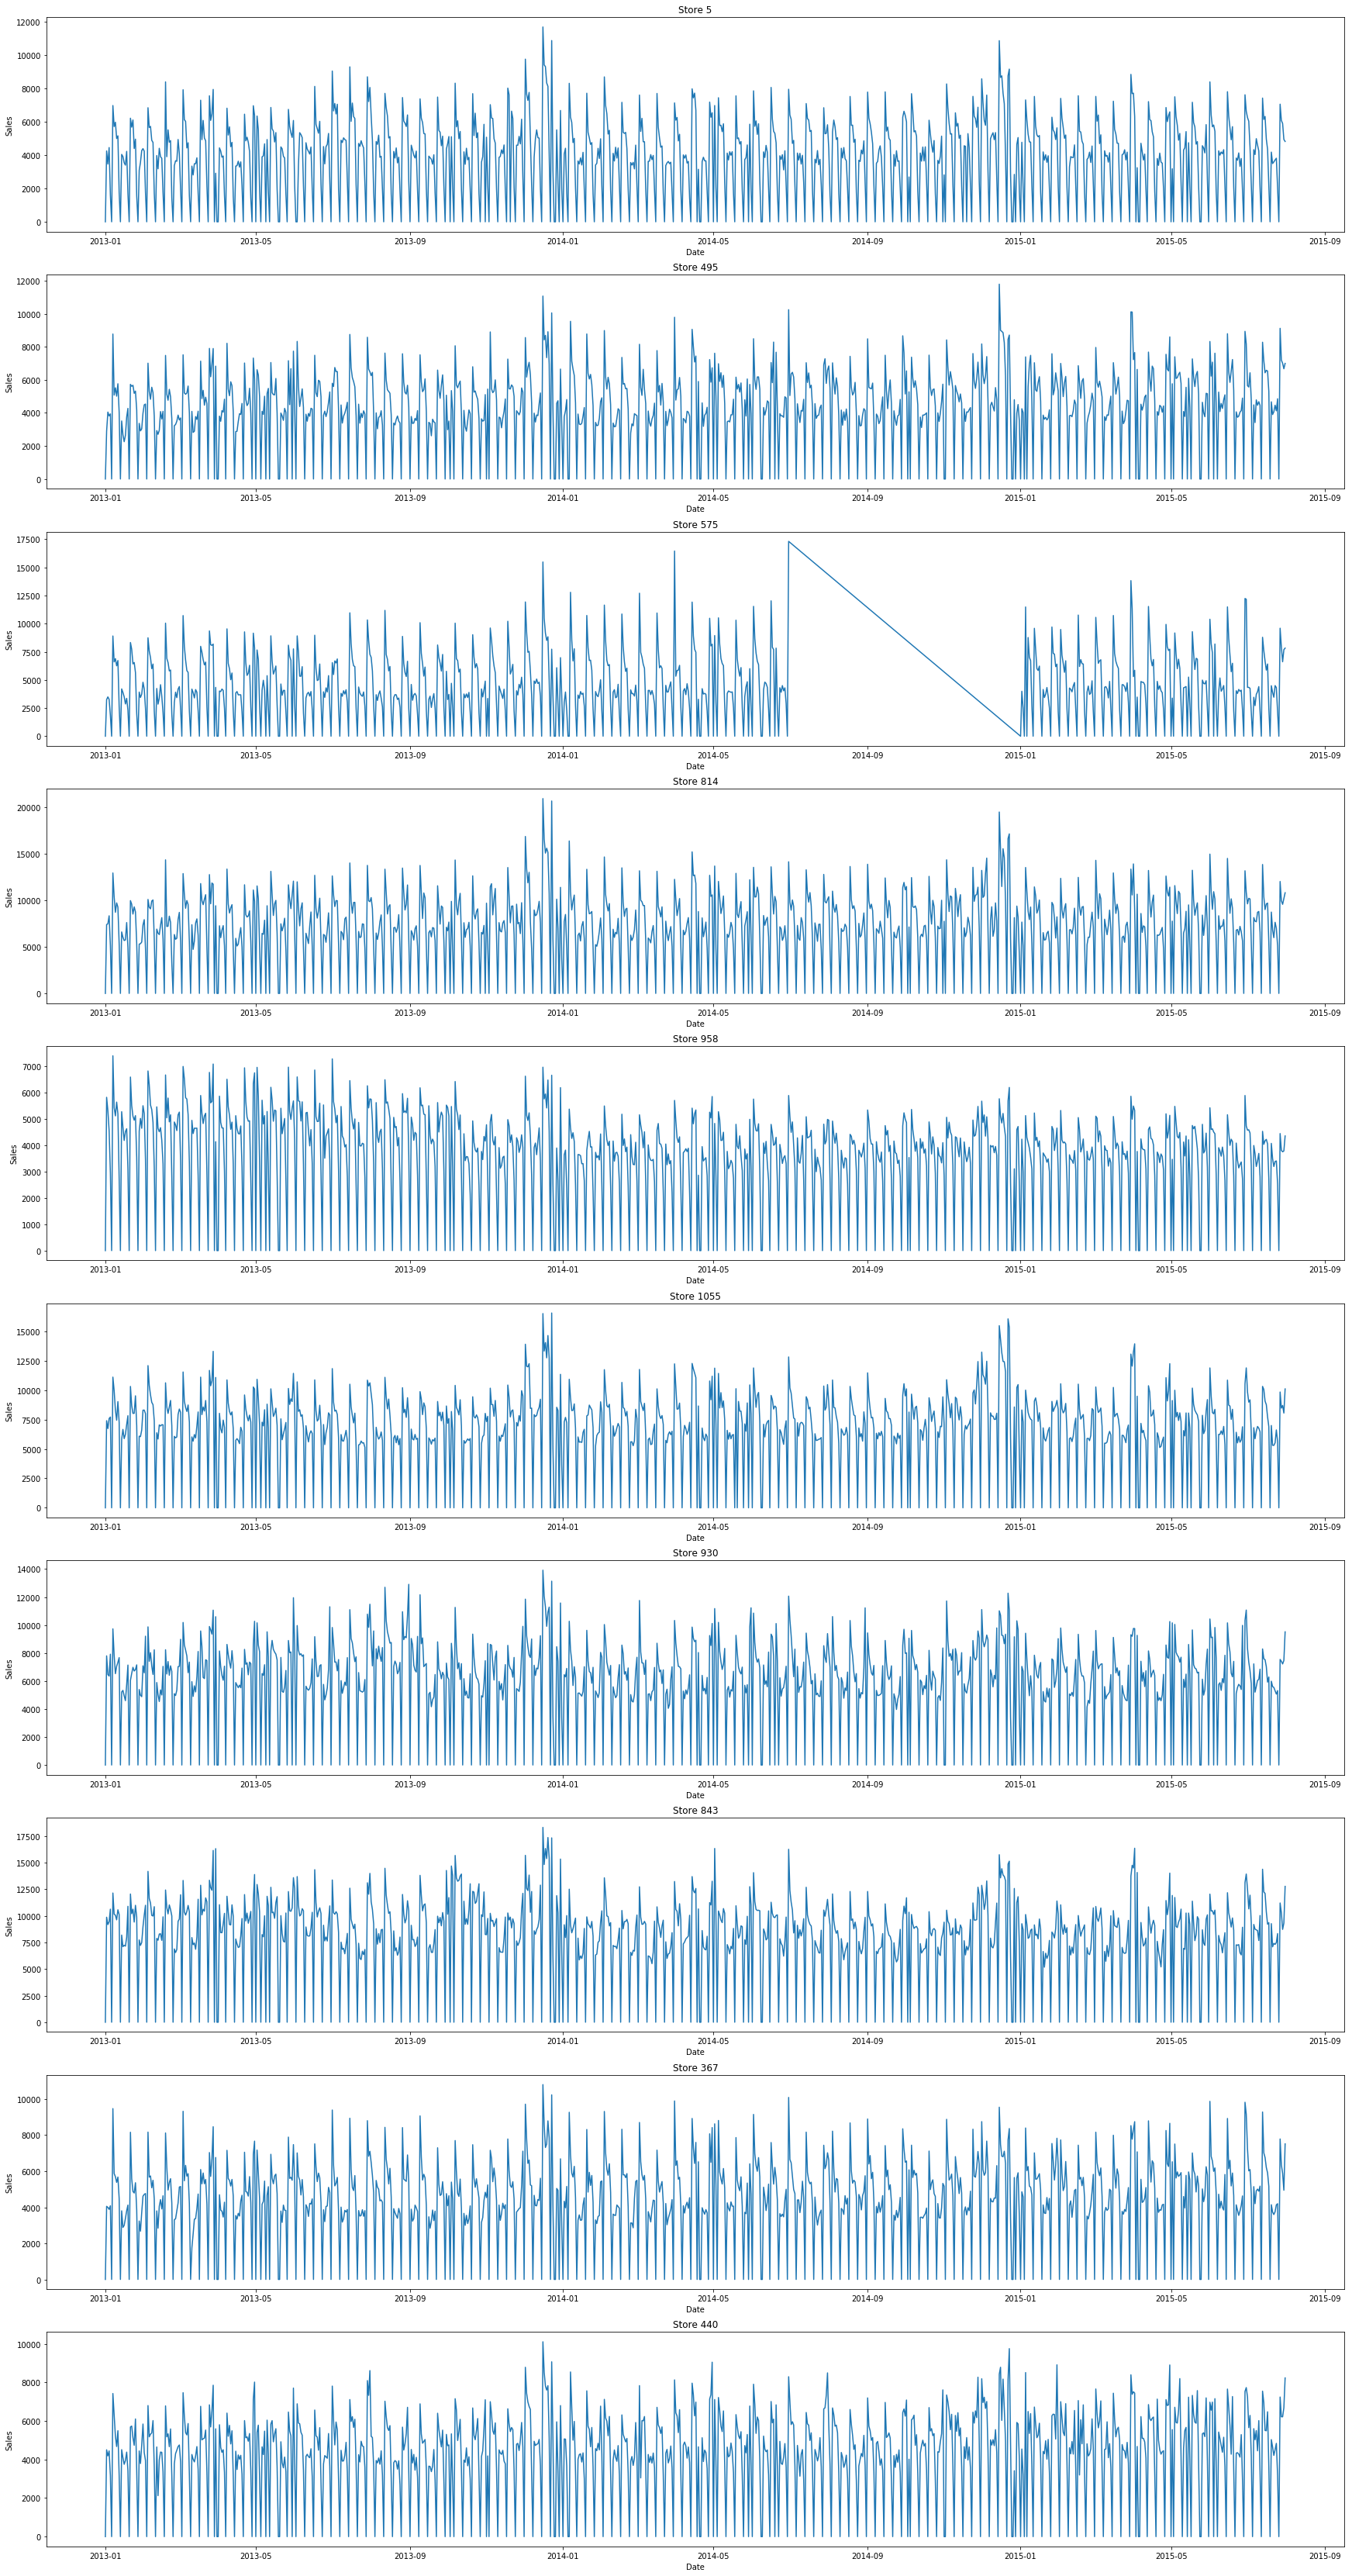

In [110]:
plot_10_store_sales()

For some stores(956 for example), there are unusualy high sales days, which need to be droped.